##  **Traffic Flow Analysis & Prediction**

This notebook builds a complete big data pipeline to analyze and forecast traffic volume in New York City using the “Automated Traffic Volume Counts” dataset. It includes data ingestion from NYC Open Data API, cleaning and preprocessing with PySpark, exploratory data analysis, time-series forecasting (ARIMA & Prophet), and machine learning-based prediction (Linear Regression, Random Forest, GBT).

### **Setup &  Data Ingestion**

This code connects to the NYC Open Data API to download traffic volume data in chunks of 50,000 records. It keeps fetching data until there’s nothing left, converts each chunk into a Spark DataFrame, and combines them into one large dataset. The final dataset is saved as a Parquet file, which is a column-based storage format that is efficient for big data tasks because it allows faster reads, better compression, and is optimized for use with tools like Spark.


In [ ]:
import os
import requests
import pandas as pd
from pyspark.sql import SparkSession

# Set Spark driver memory to 6 GB if not already set
if not os.environ.get("PYSPARK_SUBMIT_ARGS"):
    os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 6g pyspark-shell"

# Initialize a Spark session named "TrafficDataIngestion"
spark = SparkSession.builder.appName("TrafficDataIngestion").getOrCreate()

# Set the base API endpoint and pagination parameters
BASE_URL = "https://data.cityofnewyork.us/resource/7ym2-wayt.json"
# Maximum number of records to fetch per API call
LIMIT = 50000
# Offset for pagination
offset = 0
# Counter to track the number of fetched chunks
chunk_num = 0
# List to store each chunk as a Spark DataFrame
dfs = []

# Fetch traffic data in chunks until no more data is available
while True:
    # Make a GET request to fetch one chunk of data
    print(f"Fetching chunk {chunk_num} (offset={offset})...")
    response = requests.get(BASE_URL, params={"$limit": LIMIT, "$offset": offset})

    if response.status_code != 200:
        print("Error:", response.text)
        break

    # Parse the JSON response
    data = response.json()
    if not data:
        break  # No more data

    # Convert JSON data to pandas DataFrame
    pdf = pd.DataFrame(data)
    if pdf.empty:
        break

    # Convert the pandas DataFrame into a Spark DataFrame
    spark_df = spark.createDataFrame(pdf)
    # Store this chunk in the list
    dfs.append(spark_df)

    offset += LIMIT
    chunk_num += 1

# Combine all Spark dataframes
if dfs:
    full_df = dfs[0]
    for df in dfs[1:]:
        full_df = full_df.unionByName(df)
    # Save the complete dataset as a Parquet file for efficient storage and processing
    full_df.write.mode("overwrite").parquet("cleaned_traffic_data.parquet")
    print("✅ Data successfully ingested and saved as Parquet.")
else:
    print("❌ No data was fetched.")

Fetching chunk 0 (offset=0)...
Fetching chunk 1 (offset=50000)...
Fetching chunk 2 (offset=100000)...
Fetching chunk 3 (offset=150000)...
Fetching chunk 4 (offset=200000)...
Fetching chunk 5 (offset=250000)...
Fetching chunk 6 (offset=300000)...
Fetching chunk 7 (offset=350000)...
Fetching chunk 8 (offset=400000)...
Fetching chunk 9 (offset=450000)...
Fetching chunk 10 (offset=500000)...
Fetching chunk 11 (offset=550000)...
Fetching chunk 12 (offset=600000)...
Fetching chunk 13 (offset=650000)...
Fetching chunk 14 (offset=700000)...
Fetching chunk 15 (offset=750000)...
Fetching chunk 16 (offset=800000)...
Fetching chunk 17 (offset=850000)...
Fetching chunk 18 (offset=900000)...
Fetching chunk 19 (offset=950000)...
Fetching chunk 20 (offset=1000000)...
Fetching chunk 21 (offset=1050000)...
Fetching chunk 22 (offset=1100000)...
Fetching chunk 23 (offset=1150000)...
Fetching chunk 24 (offset=1200000)...
Fetching chunk 25 (offset=1250000)...
Fetching chunk 26 (offset=1300000)...
Fetching c

KeyboardInterrupt: 

In [ ]:
full_df.show(20)

+---------+--------+----+---+---+---+---+---+---------+--------------------+--------------+--------------------+--------+---------+
|requestid|    boro|  yr|  m|  d| hh| mm|vol|segmentid|             wktgeom|        street|              fromst|    tost|direction|
+---------+--------+----+---+---+---+---+---+---------+--------------------+--------------+--------------------+--------+---------+
|    32970|  Queens|2021|  4| 30|  2|  0|  0|   149701|POINT (997407.099...|PULASKI BRIDGE|Newtown Creek Sho...|Dead end|       NB|
|    32970|  Queens|2021|  4| 30|  2| 15|  1|   149701|POINT (997407.099...|PULASKI BRIDGE|Newtown Creek Sho...|Dead end|       NB|
|    11342|Brooklyn|2012| 12| 18|  8| 15| 33|    20063|POINT (985746.5 1...|         61 ST|               15 AV|   16 AV|       WB|
|    32970|  Queens|2021|  4| 30|  2| 30|  0|   149701|POINT (997407.099...|PULASKI BRIDGE|Newtown Creek Sho...|Dead end|       NB|
|    32970|  Queens|2021|  4| 30|  2| 45|  0|   149701|POINT (997407.099...|

### **Data Cleaning**

#### Checking for Null Values in Key Columns

The below code checks how many missing (null) values exist in important columns like date, time, and traffic volume. It's useful to know which fields may need cleaning or removal in the next steps.

In [ ]:
#printing the columns
print(full_df.columns)

['requestid', 'boro', 'yr', 'm', 'd', 'hh', 'mm', 'vol', 'segmentid', 'wktgeom', 'street', 'fromst', 'tost', 'direction']


In [ ]:
from pyspark.sql.functions import col

for field in ["segmentid", "vol", "yr", "m", "d", "hh", "mm"]:
    # Filter rows where the current field is null and count them
    null_count = full_df.filter(col(field).isNull()).count()
    print(f"Nulls in {field}: {null_count}")


Nulls in segmentid: 0
Nulls in vol: 0
Nulls in yr: 0
Nulls in m: 0
Nulls in d: 0
Nulls in hh: 0
Nulls in mm: 0


All key columns have 0 null values. This means the dataset is well-structured and ready for timestamp creation and further cleaning steps.

#### Timestamp Construction

This step removes duplicate and incomplete rows, filters out records with zero traffic volume, fills in missing minute values with 0, and constructs a proper timestamp column by combining year, month, day, hour, and minute. This timestamp will be used for time-series analysis and aggregations later.

In [ ]:
from pyspark.sql.functions import col, lpad, concat_ws, to_timestamp

# Remove duplicate rows based on segment ID and timestamp components
df_deduped = full_df.dropDuplicates(["segmentid", "yr", "m", "d", "hh", "mm"])

# Drop rows with null values in essential fields (volume, date, time)
essential_fields = ["segmentid", "vol", "yr", "m", "d", "hh", "mm"]
df_cleaned = df_deduped.dropna(subset=essential_fields)

# Remove rows where traffic volume is zero (likely invalid or unhelpful)
df_cleaned = df_cleaned.filter(col("vol") > 0)

# Fill any missing minute values with 0 (safely assumes :00 if missing)
df_cleaned = df_cleaned.fillna({"mm": 0})

# Create a complete timestamp column by combining padded date and time parts
df_cleaned = df_cleaned.withColumn("month_padded", lpad(col("m"), 2, "0")) \
                       .withColumn("day_padded", lpad(col("d"), 2, "0")) \
                       .withColumn("hour_padded", lpad(col("hh"), 2, "0")) \
                       .withColumn("minute_padded", lpad(col("mm"), 2, "0")) \
                       .withColumn(
                           "timestamp_string",
                           concat_ws(" ",
                               concat_ws("-", col("yr"), col("month_padded"), col("day_padded")),
                               concat_ws(":", col("hour_padded"), col("minute_padded"))
                           )
                       ) \
                       .withColumn("timestamp", to_timestamp("timestamp_string", "yyyy-MM-dd HH:mm"))


In [ ]:
df_cleaned.select("timestamp", "yr", "m", "d", "hh", "mm").show(5, truncate=False)


+-------------------+----+---+---+---+---+
|timestamp          |yr  |m  |d  |hh |mm |
+-------------------+----+---+---+---+---+
|2013-01-24 00:00:00|2013|1  |24 |0  |0  |
|2013-01-26 00:00:00|2013|1  |26 |0  |0  |
|2013-01-23 01:00:00|2013|1  |23 |1  |0  |
|2013-01-25 10:00:00|2013|1  |25 |10 |0  |
|2013-01-26 10:00:00|2013|1  |26 |10 |0  |
+-------------------+----+---+---+---+---+
only showing top 5 rows



Record Count Before and After Cleaning


This step checks how many records existed in the original dataset and how many remained after cleaning. It helps confirm the impact of cleaning steps like removing duplicates, nulls, and zero-volume rows.

In [ ]:
# Number of records initially
initial_count = full_df.count()
print(f"Initial record count: {initial_count}")

# Number of records after cleaning
cleaned_count = df_cleaned.count()
print(f"Cleaned record count: {cleaned_count}")


Initial record count: 1712605
Cleaned record count: 1437970


Duplicate Check After Cleaning

This step helps ensure data integrity before analysis or modeling.

In [ ]:
# Check for duplicates again based on essential fields (if any)
df_duplicates = df_cleaned.groupBy("segmentid", "vol", "yr", "m", "d", "hh", "mm").count().filter("count > 1")
df_duplicates.show()  # Show rows that have duplicates (if any)


+---------+---+---+---+---+---+---+-----+
|segmentid|vol| yr|  m|  d| hh| mm|count|
+---------+---+---+---+---+---+---+-----+
+---------+---+---+---+---+---+---+-----+



#### Temporal Field Parsing

The below codes helps to understand time coverage of the dataset and the data distribution over months. It gives a quick check of the earliest and latest timestamps and shows how many records exist for each year-month combination. This is useful for spotting missing periods or seasonal trends.

In [ ]:
# Check the distribution of timestamp - Get the min, max, and count
df_cleaned.select("timestamp").agg({"timestamp": "min", "timestamp": "max", "timestamp": "count"}).show()

# Get a breakdown by year/month to see any trends
df_cleaned.groupBy("yr", "m").count().orderBy("yr", "m").show(20, truncate=False)  # Show breakdown by year/month


+----------------+
|count(timestamp)|
+----------------+
|         1437970|
+----------------+

+----+---+-----+
|yr  |m  |count|
+----+---+-----+
|2000|1  |1901 |
|2006|11 |42   |
|2006|9  |311  |
|2007|10 |218  |
|2007|11 |714  |
|2007|3  |418  |
|2007|4  |5691 |
|2007|5  |556  |
|2008|3  |5731 |
|2008|4  |7276 |
|2008|5  |6234 |
|2008|6  |6010 |
|2008|7  |1196 |
|2008|8  |1769 |
|2008|9  |385  |
|2009|1  |7403 |
|2009|10 |11281|
|2009|11 |9770 |
|2009|12 |7832 |
|2009|2  |6752 |
+----+---+-----+
only showing top 20 rows



#### Outlier Detection

The below code identifies the records whose traffic vloums is an outlier using the Interquartile Range (IQR) method. Outliers may represent sensor errors or unusual traffic spikes. Knowing about the number of outliers can help us in our analysis in later stages.

In [ ]:
from pyspark.sql.functions import col

# Cast 'vol' column to Integer (or Double) type
df_cleaned = df_cleaned.withColumn("vol", col("vol").cast("int"))

# Now calculate percentiles
percentiles = df_cleaned.approxQuantile("vol", [0.25, 0.75], 0.05)

# Calculate lower and upper bounds for outlier detection
lower_bound = percentiles[0] - 1.5 * (percentiles[1] - percentiles[0])
upper_bound = percentiles[1] + 1.5 * (percentiles[1] - percentiles[0])

# Filter out the outliers
df_outliers = df_cleaned.filter((col("vol") < lower_bound) | (col("vol") > upper_bound))

df_outliers.show()  # Show rows that are potential outliers in the 'vol' column



+---------+---------+----+---+---+---+---+---+---------+--------------------+--------------------+-------------------+-------------------+---------+------------+----------+-----------+-------------+----------------+-------------------+
|requestid|     boro|  yr|  m|  d| hh| mm|vol|segmentid|             wktgeom|              street|             fromst|               tost|direction|month_padded|day_padded|hour_padded|minute_padded|timestamp_string|          timestamp|
+---------+---------+----+---+---+---+---+---+---------+--------------------+--------------------+-------------------+-------------------+---------+------------+----------+-----------+-------------+----------------+-------------------+
|    21146|   Queens|2016|  1| 21| 15|  0|334|   101869|POINT (1057404.6 ...|       NORTHERN BLVD|        BROWVALE LA|   LITTLE NECK PKWY|       NB|          01|        21|         15|           00|2016-01-21 15:00|2016-01-21 15:00:00|
|    21146|   Queens|2016|  1| 20|  8|  0|322|   101869|

#### Distinct Count of Spatial Features



This step counts how many unique boroughs, street names, and intersections are present in the data. It helps confirm that the dataset covers a wide range of areas and streets, which is important for meaningful traffic analysis across different locations.

In [ ]:
# Get distinct counts for 'boro', 'fromst', 'tost', and 'street'
distinct_boro_count = df_cleaned.select("boro").distinct().count()
distinct_fromst_count = df_cleaned.select("fromst").distinct().count()
distinct_tost_count = df_cleaned.select("tost").distinct().count()
distinct_street_count = df_cleaned.select("street").distinct().count()

# Print the distinct counts
print(f"Distinct count of 'boro': {distinct_boro_count}")
print(f"Distinct count of 'fromst': {distinct_fromst_count}")
print(f"Distinct count of 'tost': {distinct_tost_count}")
print(f"Distinct count of 'street': {distinct_street_count}")


Distinct count of 'boro': 5
Distinct count of 'fromst': 2163
Distinct count of 'tost': 2047
Distinct count of 'street': 2297


#### Viewing Unique Location Names

The below code displays all the unique values in location columns like borough, from-street, to-street, and street name. We do this to check for any inconsistencies in naming. For example, values like "manhattan" and "Manhattan" might be treated as different even though they refer to the same place. Spotting such issues early helps ensure accurate grouping and analysis later.

In [ ]:
# Get distinct names for 'boro', 'fromst', 'tost', and 'street'
print("Distinct 'boro' names:")
df_cleaned.select("boro").distinct().show(truncate=False)

print("Distinct 'fromst' names:")
df_cleaned.select("fromst").distinct().show(truncate=False)

print("Distinct 'tost' names:")
df_cleaned.select("tost").distinct().show(truncate=False)

print("Distinct 'street' names:")
df_cleaned.select("street").distinct().show(truncate=False)


Distinct 'boro' names:
+-------------+
|boro         |
+-------------+
|Queens       |
|Brooklyn     |
|Staten Island|
|Manhattan    |
|Bronx        |
+-------------+

Distinct 'fromst' names:
+-------------------------------+
|fromst                         |
+-------------------------------+
|47 AVENUE                      |
|CROSBY AV                      |
|8 Avenue Line                  |
|COURT SQUARE                   |
|ARGYLE RD                      |
|UTICA AV                       |
|STAFFORD AV                    |
|AV N                           |
|JEWETT AV                      |
|6 Avenue                       |
|Billop Avenue                  |
|143 Street                     |
|FOREST AV                      |
|2 AV                           |
|GENESEE AV                     |
|CASTLETON AV                   |
|Bronx Rvr Py Nb En Pelham Py Eb|
|W 79 ST/HHP NB EXIT 10 W       |
|WOODRUFF AV                    |
|Crown Street                   |
+------------------------

The results show that there are no such inconsistencies, meaning the names are already clean and consistently formatted.

#### Extracting Latitude and Longitude from WKT Geometry

The wktgeom column stores geographic coordinates as a string in the format "POINT (longitude latitude)". The below code extracts the numeric longitude and latitude values from that string using regular expressions. These values are then stored in two new columns: longitude and latitude. This makes it easier to use the coordinates for mapping and spatial analysis later in the workflow.

In [ ]:
from pyspark.sql.functions import regexp_extract

# Extract X (longitude) and Y (latitude) from WKT "POINT (x y)"
df_cleaned = df_cleaned.withColumn("longitude", regexp_extract("wktgeom", r'POINT \(([\d\.]+)', 1).cast("double")) \
                       .withColumn("latitude", regexp_extract("wktgeom", r'POINT \([\d\.]+ ([\d\.]+)\)', 1).cast("double"))

df_cleaned.select("wktgeom", "longitude", "latitude").show(5, truncate=False)


+--------------------------+---------+--------+
|wktgeom                   |longitude|latitude|
+--------------------------+---------+--------+
|POINT (1050472.6 213322.7)|1050472.6|213322.7|
|POINT (1050472.6 213322.7)|1050472.6|213322.7|
|POINT (1050472.6 213322.7)|1050472.6|213322.7|
|POINT (1050472.6 213322.7)|1050472.6|213322.7|
|POINT (1050472.6 213322.7)|1050472.6|213322.7|
+--------------------------+---------+--------+
only showing top 5 rows



#### Hourly Traffic Volume Aggregation

We calculate the total traffic volume per hour by grouping the data by year, month, day, and hour. It helps identify hourly traffic patterns across all days in the dataset, which is useful for analyzing rush hours or low-traffic periods.

In [ ]:
from pyspark.sql.functions import sum as _sum

# Group data by year, month, day, and hour, then sum up traffic volume for each group
hourly_traffic = df_cleaned.groupBy("yr", "m", "d", "hh") \
    .agg(_sum("vol").alias("total_volume_hourly")) \
    .orderBy("yr", "m", "d", "hh")

hourly_traffic.show(10, truncate=False)


+----+---+---+---+-------------------+
|yr  |m  |d  |hh |total_volume_hourly|
+----+---+---+---+-------------------+
|2000|1  |1  |0  |962                |
|2000|1  |1  |1  |1359               |
|2000|1  |1  |10 |1511               |
|2000|1  |1  |11 |1550               |
|2000|1  |1  |12 |1314               |
|2000|1  |1  |13 |1213               |
|2000|1  |1  |14 |1204               |
|2000|1  |1  |15 |1147               |
|2000|1  |1  |16 |1041               |
|2000|1  |1  |17 |882                |
+----+---+---+---+-------------------+
only showing top 10 rows



#### Daily Traffic Volume Aggregation


We calculate the total vehicle count per day by grouping the data based on year, month, and day. It helps in identifying overall daily traffic trends, such as weekday vs. weekend patterns, or detecting unusually high or low traffic days.

In [ ]:
# Group data by year, month, and day to compute total daily traffic volume
# Then sum volume per day and sort the results by date
daily_traffic = df_cleaned.groupBy("yr", "m", "d") \
    .agg(_sum("vol").alias("total_volume_daily")) \
    .orderBy("yr", "m", "d")

daily_traffic.show(10, truncate=False)


+----+---+---+------------------+
|yr  |m  |d  |total_volume_daily|
+----+---+---+------------------+
|2000|1  |1  |29404             |
|2000|1  |10 |6903              |
|2000|1  |11 |6078              |
|2000|1  |12 |6090              |
|2000|1  |2  |29016             |
|2000|1  |3  |22752             |
|2000|1  |4  |24271             |
|2000|1  |5  |26687             |
|2000|1  |6  |27335             |
|2000|1  |7  |28391             |
+----+---+---+------------------+
only showing top 10 rows



#### Hourly Volume by Segment

We calculate the traffic volume at a specific time and location by grouping records by segment ID, date, and hour. It helps identify when and where traffic is highest — useful for hotspot detection, anomaly analysis, and forecasting.

In [ ]:
spatiotemporal_traffic = df_cleaned.groupBy("segmentid", "yr", "m", "d", "hh") \
    .agg(_sum("vol").alias("volume")) \
    .orderBy("segmentid", "yr", "m", "d", "hh")

spatiotemporal_traffic.show(10, truncate=False)

+---------+----+---+---+---+------+
|segmentid|yr  |m  |d  |hh |volume|
+---------+----+---+---+---+------+
|101080   |2013|1  |22 |11 |56    |
|101080   |2013|1  |22 |12 |107   |
|101080   |2013|1  |22 |13 |139   |
|101080   |2013|1  |22 |14 |149   |
|101080   |2013|1  |22 |15 |177   |
|101080   |2013|1  |22 |16 |156   |
|101080   |2013|1  |22 |17 |191   |
|101080   |2013|1  |22 |18 |117   |
|101080   |2013|1  |22 |19 |119   |
|101080   |2013|1  |22 |20 |88    |
+---------+----+---+---+---+------+
only showing top 10 rows



### **Exploratory Analysis**


The exploratory data analysis aimed to uncover initial patterns, detect anomalies, and understand the overall structure of the traffic dataset. This stage provided essential context for later processing and modeling steps by revealing the nature of key features, especially traffic volume.

In [ ]:
#understand distribution, central tendency, and spread
df_cleaned.describe(["vol"]).show()

+-------+------------------+
|summary|               vol|
+-------+------------------+
|  count|           1437970|
|   mean|123.74284651279234|
| stddev|203.48941825130197|
|    min|                 1|
|    max|              5425|
+-------+------------------+



In [ ]:
# You've already calculated bounds – count how many values fall outside
outlier_count = df_outliers.count()
total_count = df_cleaned.count()

print(outlier_count)
print(total_count)

129566
1437970


#### Skewness and Kurtosis of Traffic Volume

To evaluate the distribution of traffic volume (vol), the skewness and kurtosis were computed using PySpark

In [ ]:
from pyspark.sql.functions import skewness, kurtosis
df_cleaned.select(skewness("vol"), kurtosis("vol")).show()


+-----------------+-----------------+
|    skewness(vol)|    kurtosis(vol)|
+-----------------+-----------------+
|6.859680174645571|90.96356452691569|
+-----------------+-----------------+



#### Average Hourly Traffic Volume
This code calculates the average traffic volume for each hour across all days. It first aggregates daily hourly volumes, then computes hourly averages, and finally converts the result to a Pandas DataFrame for visualization.

In [ ]:
from pyspark.sql.functions import sum as _sum, avg

# Step 1: Daily volume per hour
daily_hourly_traffic = df_cleaned.groupBy("yr", "m", "d", "hh") \
    .agg(_sum("vol").alias("daily_hourly_volume"))

# Step 2: Average volume for each hour (across all days)
avg_hourly_traffic = daily_hourly_traffic.groupBy("hh") \
    .agg(avg("daily_hourly_volume").alias("avg_volume_per_hour")) \
    .orderBy("hh")

# Convert to pandas for plotting
hourly_avg_df = avg_hourly_traffic.toPandas()

# Ensure proper type and order
hourly_avg_df["hh"] = hourly_avg_df["hh"].astype(int)
hourly_avg_df = hourly_avg_df.sort_values("hh")


This code creates a bar chart using Matplotlib to visualize the average traffic volume for each hour of the day.

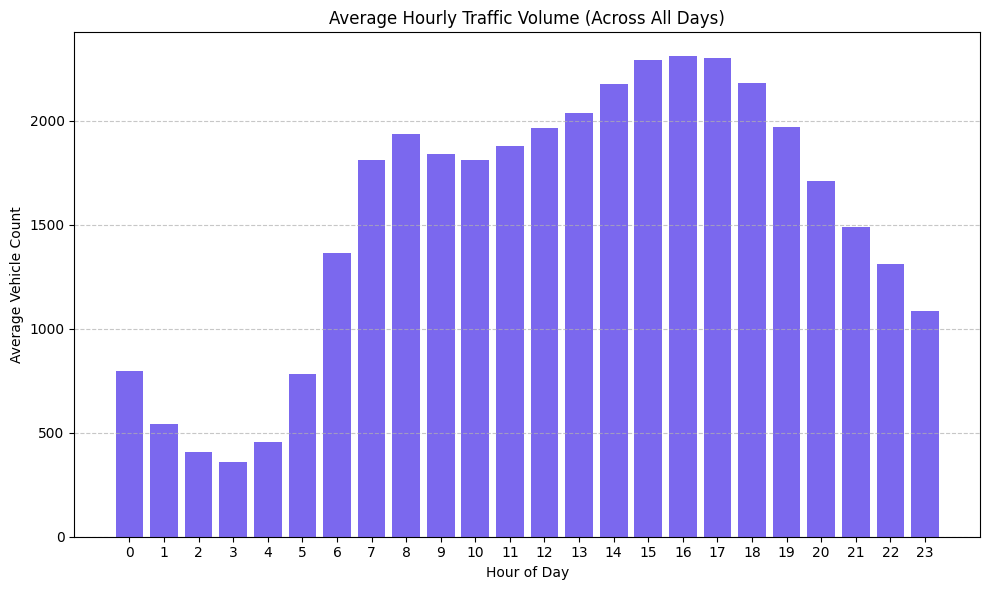

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(hourly_avg_df["hh"], hourly_avg_df["avg_volume_per_hour"], color='mediumslateblue')
plt.title("Average Hourly Traffic Volume (Across All Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicle Count")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Average Daily Traffic Volume per Month
This code calculates the average daily traffic volume for each month. It first computes the total volume per day, then averages these daily volumes by month, and converts the result to a sorted Pandas DataFrame for further analysis or visualization.

In [ ]:
# Step 1: Compute total volume for each day
daily_volume = df_cleaned.groupBy("yr", "m", "d") \
    .agg(_sum("vol").alias("daily_volume"))

# Step 2: Take average of daily volumes for each month
avg_monthly_volume = daily_volume.groupBy("m") \
    .agg(avg("daily_volume").alias("avg_daily_volume_per_month")) \
    .orderBy("m")

monthly_avg_df = avg_monthly_volume.toPandas()

# Ensure month is integer and sorted
monthly_avg_df["m"] = monthly_avg_df["m"].astype(int)
monthly_avg_df = monthly_avg_df.sort_values("m")

This Matplotlib code generates a bar chart to visualize the average daily traffic volume for each month

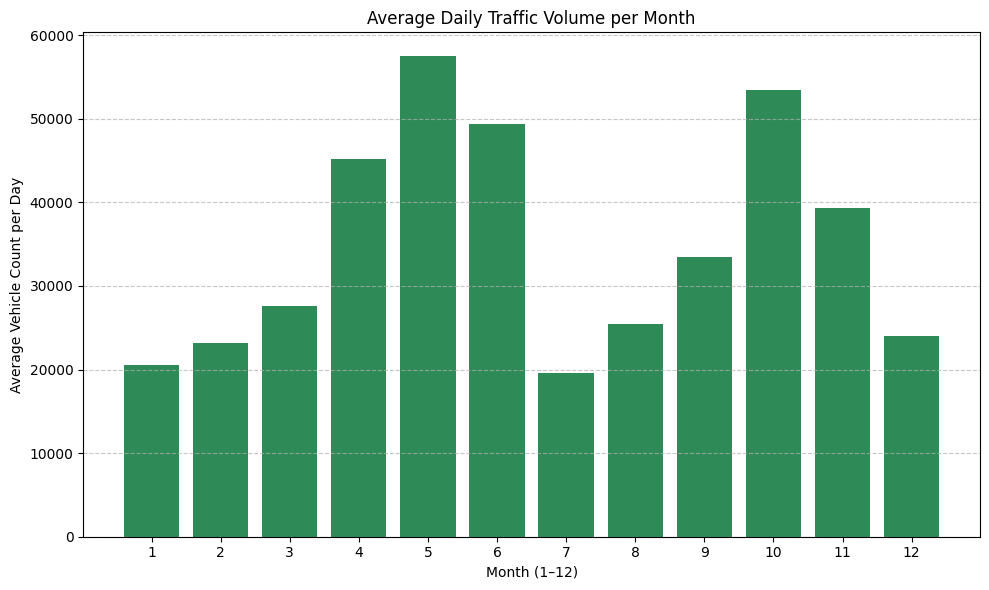

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg_df["m"], monthly_avg_df["avg_daily_volume_per_month"], color='seagreen')
plt.title("Average Daily Traffic Volume per Month")
plt.xlabel("Month (1–12)")
plt.ylabel("Average Vehicle Count per Day")
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Total volume by segment

This code calculates the total traffic volume for each road segment and displays the top 20 segments with the highest traffic, sorted in descending order.

In [ ]:
segment_traffic = df_cleaned.groupBy("segmentid") \
    .agg(_sum("vol").alias("total_volume_by_segment")) \
    .orderBy("total_volume_by_segment", ascending=False)

segment_traffic.show(20, truncate=False)


+---------+-----------------------+
|segmentid|total_volume_by_segment|
+---------+-----------------------+
|134798   |1962903                |
|138592   |1948079                |
|141152   |1881042                |
|22139    |1879029                |
|95879    |1833957                |
|72887    |1432368                |
|140178   |1397533                |
|154271   |1365318                |
|136811   |1361823                |
|140064   |1311630                |
|9009362  |1219892                |
|64066    |1194178                |
|149198   |1061937                |
|194998   |1022478                |
|153405   |1016239                |
|149701   |997536                 |
|156016   |989018                 |
|151673   |966114                 |
|62497    |957393                 |
|135187   |933481                 |
+---------+-----------------------+
only showing top 20 rows



This code visualizes the top 20 high-traffic road segments using a bar chart, showing total volume per segment with rotated x-axis labels for readability.

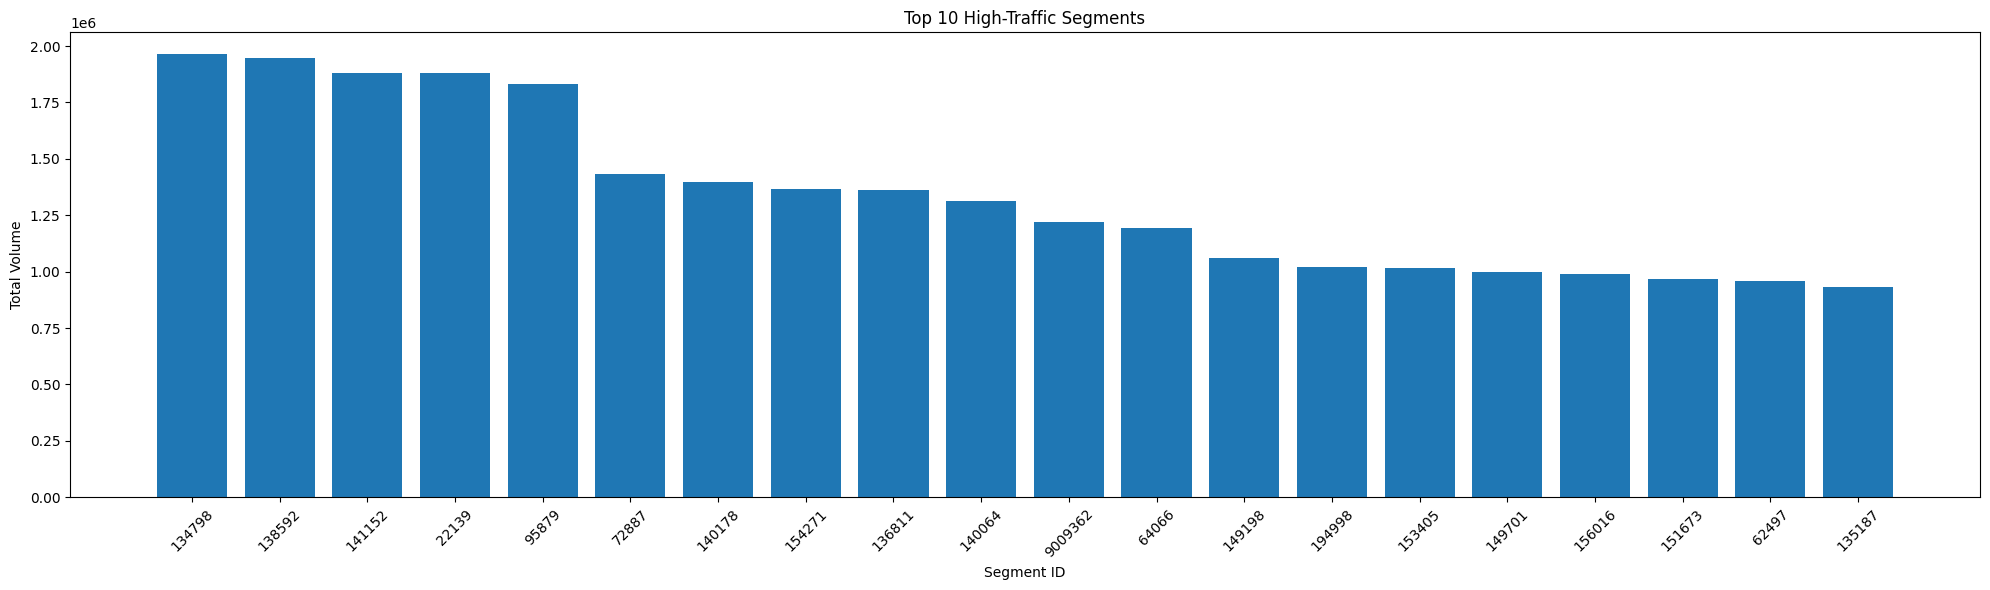

In [ ]:
import matplotlib.pyplot as plt

top_segments = segment_traffic.limit(20).toPandas()
plt.figure(figsize=(20,6))
plt.bar(top_segments['segmentid'], top_segments['total_volume_by_segment'])
plt.title("Top 10 High-Traffic Segments")
plt.xlabel("Segment ID")
plt.ylabel("Total Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Volume Distribution by Borough and Direction

In [ ]:
df_cleaned.groupBy("boro", "direction").agg(_sum("vol").alias("total_vol")).orderBy("total_vol", ascending=False).show()


+-------------+---------+---------+
|         boro|direction|total_vol|
+-------------+---------+---------+
|    Manhattan|       SB| 13875608|
|       Queens|       WB| 13062143|
|       Queens|       EB| 13045073|
|       Queens|       NB| 12916675|
|     Brooklyn|       NB| 11344955|
|     Brooklyn|       WB| 11180756|
|     Brooklyn|       EB| 10740036|
|    Manhattan|       NB| 10547929|
|        Bronx|       SB| 10504951|
|       Queens|       SB| 10465318|
|     Brooklyn|       SB| 10318197|
|        Bronx|       NB|  9378180|
|    Manhattan|       EB|  8452650|
|    Manhattan|       WB|  7823372|
|        Bronx|       WB|  7480880|
|        Bronx|       EB|  6822542|
|Staten Island|       NB|  3162839|
|Staten Island|       SB|  2874158|
|Staten Island|       EB|  1674531|
|Staten Island|       WB|  1483244|
+-------------+---------+---------+
only showing top 20 rows



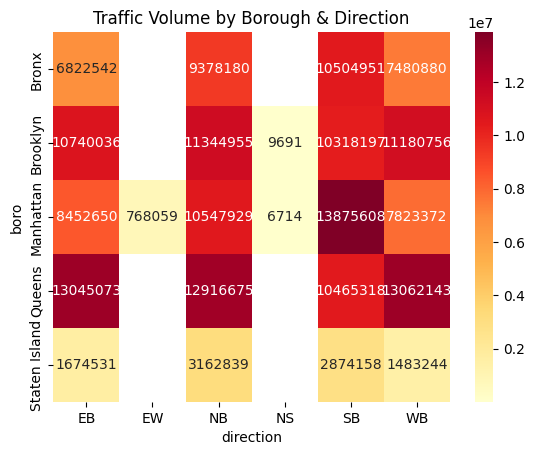

In [ ]:
import seaborn as sns

boro_direction_df = df_cleaned.groupBy("boro", "direction") \
    .agg(_sum("vol").alias("total_volume")) \
    .toPandas()

pivot = boro_direction_df.pivot(index="boro", columns="direction", values="total_volume")
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Traffic Volume by Borough & Direction")
plt.show()


#### Heatmap of Hour vs Day (to identify peak hours)

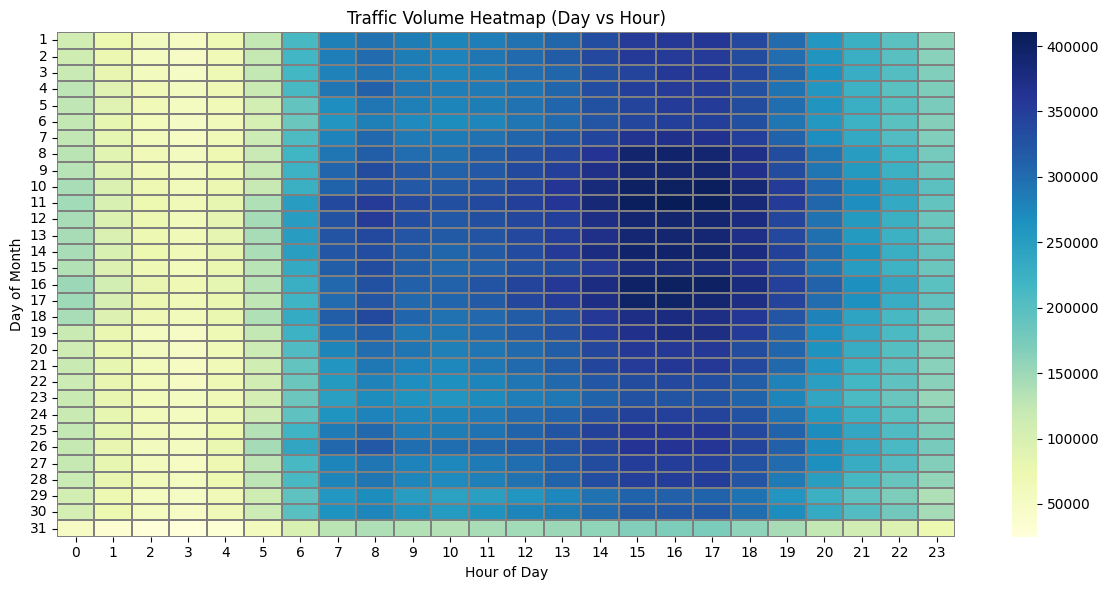

In [ ]:
heat_df = df_cleaned.groupBy("d", "hh").agg(_sum("vol").alias("vol")).toPandas()
pivot = heat_df.pivot(index="d", columns="hh", values="vol")

# Fix column types (in case they’re strings)
heat_df["d"] = heat_df["d"].astype(int)
heat_df["hh"] = heat_df["hh"].astype(int)

# Pivot table: rows = day, columns = hour
pivot = heat_df.pivot(index="d", columns="hh", values="vol")

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.1, linecolor='gray')
plt.title("Traffic Volume Heatmap (Day vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Month")
plt.tight_layout()
plt.show()

### **Temporal Trend Forecasting (ARIMA & Prophet)**

The below step converts the cleaned Spark DataFrame to a Pandas DataFrame and prepares it for time-series modeling. We:
- Select the timestamp and volume columns
- Resample the data to hourly frequency (since traffic is logged every 15 minutes)
- Rename columns as required by Prophet
- Fill in any missing time intervals using forward fill to maintain continuity

In [ ]:
# Convert Spark DataFrame to Pandas for ARIMA/Prophet modeling
df_pandas = df_cleaned.select("timestamp", "vol").toPandas()
df_pandas['timestamp'] = pd.to_datetime(df_pandas['timestamp'])
df_pandas = df_pandas.set_index('timestamp').resample('H').sum().reset_index()
df_pandas.columns = ['ds', 'y']  # Rename for Prophet

# Fill missing time intervals (forward fill)
df_pandas['y'] = df_pandas['y'].fillna(method='ffill')


<ipython-input-29-709c2304ffc0>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pandas = df_pandas.set_index('timestamp').resample('H').sum().reset_index()
<ipython-input-29-709c2304ffc0>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pandas['y'] = df_pandas['y'].fillna(method='ffill')


We use the ARIMA (AutoRegressive Integrated Moving Average) model to forecast traffic volume for the next 24 hours. The dataset is split into training and test sets:
- The model is trained on all data except the last 24 hours
- It then predicts the next 24 hours
- RMSE is used to evaluate how close the predictions are to the actual values

In [ ]:
# ARIMA Forecasting
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = df_pandas.iloc[:-24]
test = df_pandas.iloc[-24:]

model = ARIMA(train['y'], order=(2, 1, 2))
fitted_model = model.fit()
predictions_arima = fitted_model.forecast(steps=24)
rmse_arima = np.sqrt(mean_squared_error(test['y'], predictions_arima))
print(f"ARIMA RMSE (24 hr): {rmse_arima:.2f}")

ARIMA RMSE (24 hr): 445.93



Prophet is a forecasting model developed by Facebook that works well with time-series data that shows trends and seasonality.  
Here, we use Prophet to forecast NYC traffic volume for the next 24 hours, based on hourly historical data.  
The forecast is visualized to show predicted traffic patterns with uncertainty intervals.

DEBUG:cmdstanpy:input tempfile: /tmp/tmppugwupri/cq90yds9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppugwupri/dqw8urub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18151', 'data', 'file=/tmp/tmppugwupri/cq90yds9.json', 'init=/tmp/tmppugwupri/dqw8urub.json', 'output', 'file=/tmp/tmppugwupri/prophet_modelh0u0fuzf/prophet_model-20250506225715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:57:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


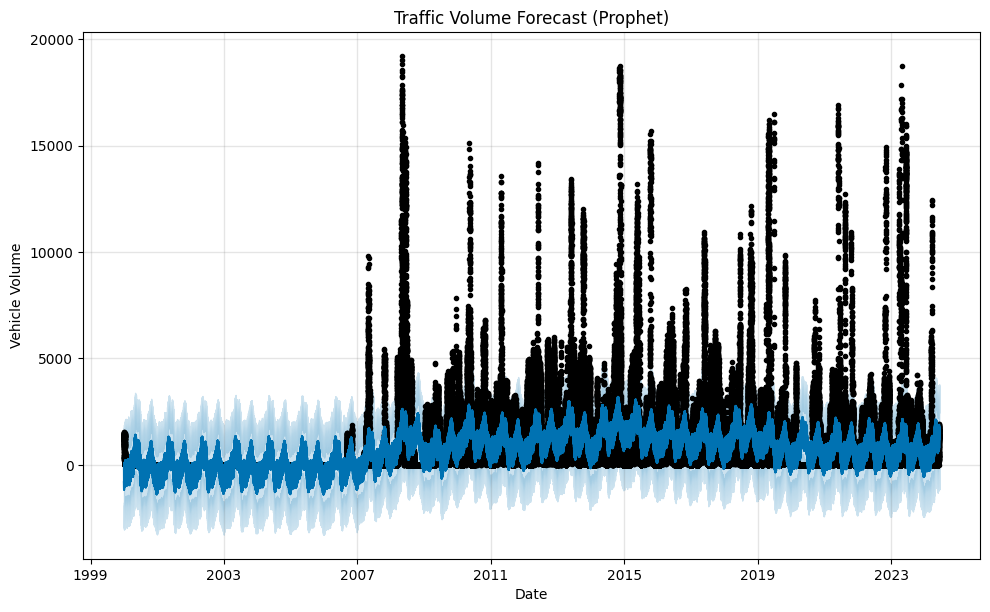

In [ ]:
# Prophet Forecasting
from prophet import Prophet

prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_pandas)

future = prophet_model.make_future_dataframe(periods=24, freq='H')
forecast = prophet_model.predict(future)

# Plot forecast
fig = prophet_model.plot(forecast)
plt.title("Traffic Volume Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Vehicle Volume")
plt.grid(True)

### **Predictive Modelling**

In [ ]:
from pyspark.sql.functions import dayofweek
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml import Pipeline

#### Feature Engineering

We prepare the dataset for machine learning by creating new features and transforming categorical variables. We extract day of week, encode borough and direction into numeric vectors, and assemble everything into a single features column. This prepares the data for training models.

In [ ]:
#Create calendar-based features and rename 'vol' to 'label' for ML compatibility

#In the below code:
#We add a new column for day of the week (1 = Sunday, ..., 7 = Saturday)
#Rename the target column 'vol' to 'label' (required by Spark ML)
# Select numeric features and also include categorical features
df_feat = (df_cleaned
           .withColumn("dow", dayofweek("timestamp"))          # 1=Sunday … 7=Saturday
           .withColumnRenamed("vol", "label")                 # rename target column
           .select("label", "yr", "m", "d", "hh", "dow",       # numerical features
                   "boro", "direction"))                       # categorical features
#One-hot encoding
#Convert categorical columns (boro and direction) to numeric format using indexing
boro_index  = StringIndexer(inputCol="boro",      outputCol="boro_idx",   handleInvalid="keep")
dir_index   = StringIndexer(inputCol="direction", outputCol="dir_idx",    handleInvalid="keep")

#Convert the indexed columns into one-hot encoded vectors (e.g., [0,1,0])
boro_ohe    = OneHotEncoder(inputCol="boro_idx",  outputCol="boro_ohe")
dir_ohe     = OneHotEncoder(inputCol="dir_idx",   outputCol="dir_ohe")

#Combine all features into one vector column called 'features_raw'
assembler = VectorAssembler(
    inputCols=["yr", "m", "d", "hh", "dow", "boro_ohe", "dir_ohe"],
    outputCol="features_raw"
)

# Scale the feature vector so that all features have similar range (zero mean, unit variance)
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

# List of all preprocessing steps to be applied before training the model
preprocess_stages = [boro_index, dir_index, boro_ohe, dir_ohe, assembler, scaler]

In the below code we make sure that all date and time columns (year, month, day, hour) are in the correct integer format and adds a new feature for day of the week. Only the needed columns are selected for modeling.

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# List of numeric columns that should be explicitly cast to integers
numeric_cols = ["yr", "m", "d", "hh"]

df_cast = df_cleaned
# Make sure year, month, day, and hour columns are of integer type
for c in numeric_cols:
    df_cast = df_cast.withColumn(c, col(c).cast(IntegerType()))

# Create a new DataFrame with selected features for modeling
from pyspark.sql.functions import dayofweek
df_feat = (df_cast
           .withColumn("dow", dayofweek("timestamp"))
           .withColumnRenamed("vol", "label")
           .select("label", "yr", "m", "d", "hh", "dow",
                   "boro", "direction"))

# Create a new DataFrame with selected features for modeling
for c in ["yr", "m", "d", "hh"]:
    df_feat = df_feat.withColumn(c, col(c).cast("int"))

#### Train / Test split

The below code splits the dataset into training and testing sets using a 60/40 ratio. It then repartitions the data for better parallel processing and samples 60% of the training data to reduce training time while keeping it representative.

In [ ]:
# Split the feature data into 60% training and 40% testing
train_df, test_df = df_feat.randomSplit([0.6, 0.4], seed=42)

# Repartition both datasets into 8 partitions to improve processing speed in Spark
train_df = train_df.repartition(8)
test_df = test_df.repartition(8)

# Sample 60% of the training data to speed up model training
train_df = train_df.sample(fraction=0.6, seed=42)

#### Model Setup

In the below code we set up three machine learning models — Linear Regression, Random Forest, and Gradient-Boosted Trees — along with hyperparameter tuning using cross-validation. A CrossValidator is used to automatically test different combinations of model parameters and select the one that gives the best performance based on Root Mean Squared Error (RMSE).


For each model:

* We define a parameter grid (e.g., `regParam`, `maxDepth`, `numTrees`) to try different values.

* We use cross-validation (`numFolds=2 or 3`) to split the training data into folds and evaluate performance on unseen data.

* `parallelism` is set to speed up the process by evaluating multiple combinations at once.

Each model is wrapped in a pipeline that includes feature preprocessing and training. This makes it easy to apply the same transformations consistently.

In [ ]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning      import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation  import RegressionEvaluator

# Define evaluation metrics for model performance
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
mae_evaluator  = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mae")

#(i) Linear Regression
# Create a linear regression model with L1/L2 regularization (elasticNetParam = 0.8)
lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, elasticNetParam=0.8)

# Define grid for hyperparameter tuning
lr_grid = (ParamGridBuilder()
           .addGrid(lr.regParam,        [0.001, 0.01, 0.1]) # Regularization strength
           .addGrid(lr.elasticNetParam, [0.0,   0.5, 1.0])  # Mix of L1 (Lasso) and L2 (Ridge)
           .build())

# Cross-validation setup for linear regression
# During cross-validation only RMSE value is used for optimising
lr_cv = CrossValidator(
    estimator=Pipeline(stages=preprocess_stages + [lr]), # Preprocessing + model pipeline
    estimatorParamMaps=lr_grid, # Grid search for tuning
    evaluator=evaluator, # Evaluate using RMSE
    numFolds=3, # 3-fold cross-validation
    parallelism=4 # Run folds in parallel
)


#(ii) Random Forest
# Create a random forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Define grid for tuning number of trees and max depth
rf_grid = (ParamGridBuilder()
           .addGrid(rf.numTrees,  [50, 100]) # Number of trees in the forest
           .addGrid(rf.maxDepth,  [10, 15]) # Maximum depth of each tree
           .build())

# Cross-validation setup for random forest
rf_cv = CrossValidator(
    estimator=Pipeline(stages=preprocess_stages + [rf]),
    estimatorParamMaps=rf_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=2
)

#(iii) Gradient-Boosted Trees
# Create a GBT regressor with subsampling
gbt = GBTRegressor(featuresCol="features", labelCol="label", seed=42, subsamplingRate=0.8)

# Define grid for tuning iterations and depth
gbt_grid = (ParamGridBuilder()
            .addGrid(gbt.maxIter, [30, 60]) # Number of boosting rounds
            .addGrid(gbt.maxDepth, [5, 8])  # Tree depth
            .build())

# Cross-validation setup for GBT
gbt_cv = CrossValidator(
    estimator=Pipeline(stages=preprocess_stages + [gbt]),
    estimatorParamMaps=gbt_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=2
)


#### Model Training

We train all the three models using the training data. Then, we evaluate their performance on the test set using two metrics: **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)**. RMSE penalizes larger errors more, while MAE gives a general idea of average error size. This comparison helps us choose the best-performing model.

In [ ]:
# Train Linear Regression and evaluate on test set
print("\n▶ Training Linear Reg …")
lr_model = lr_cv.fit(train_df)
lr_rmse = evaluator.evaluate(lr_model.transform(test_df))
lr_mae  = mae_evaluator.evaluate(lr_model.transform(test_df))
print(f"   Linear Reg test RMSE: {lr_rmse:,.2f}")
print(f"   Linear Reg test MAE:  {lr_mae:,.2f}")




▶ Training Linear Reg …
   Linear Reg test RMSE: 200.43
   Linear Reg test MAE:  105.14


In [ ]:
# Train Random Forest and evaluate
print("\n▶ Training Random Forest …")
rf_model = rf_cv.fit(train_df)
rf_rmse = evaluator.evaluate(rf_model.transform(test_df))
rf_mae  = mae_evaluator.evaluate(rf_model.transform(test_df))
print(f"   Random Forest test RMSE: {rf_rmse:,.2f}")
print(f"   Random Forest test MAE:  {rf_mae:,.2f}")


▶ Training Random Forest …
   Random Forest test RMSE: 104.34
   Random Forest test MAE:  55.83


In [ ]:
# Train Gradient-Boosted Trees and evaluate
print("\n▶ Training GBT …")
gbt_model = gbt_cv.fit(train_df)
gbt_rmse = evaluator.evaluate(gbt_model.transform(test_df))
gbt_mae  = mae_evaluator.evaluate(gbt_model.transform(test_df))
print(f"   GBT test RMSE: {gbt_rmse:,.2f}")
print(f"   GBT test MAE:  {gbt_mae:,.2f}")


▶ Training GBT …
   GBT test RMSE: 97.88
   GBT test MAE:  54.16


#### Choosing the Best Model

In the above code we report both RMSE and MAE values but we use RMSE to select the best model because it gives more weight to larger errors, which is often preferred in real-world applications and competitions. This helps us prioritize models that are not only accurate on average but also avoid large mistakes.

In [ ]:
# Store RMSE, MAE, and trained model object for each model
model_results = {
    "Linear Reg":     (lr_rmse, lr_mae, lr_model),
    "Random Forest":  (rf_rmse, rf_mae, rf_model),
    "GBT":            (gbt_rmse, gbt_mae, gbt_model)
}

# Choose the model with the lowest RMSE (index 0 of each tuple)
best_name = min(model_results, key=lambda x: model_results[x][0])

# Unpack all values: RMSE, MAE, and model object
best_rmse, best_mae, best_model = model_results[best_name]

# Print the best model name and its RMSE
print(f"\nBest model: {best_name} with RMSE {best_rmse:,.2f}")


Best model: GBT with RMSE 97.88


#### Save and Reload the Best Model

Saving the trained model allows to reuse it later without retraining. You can reload the model using PipelineModel.load() when needed.

In [ ]:
# Save the best model to disk
best_model.save("spark_best_traffic_model")

#### Predictions and Result Visualization

This part shows how well the model is performing by predicting traffic volumes on a small test sample and plotting the actual vs predicted values. The closer the points are to the diagonal line, the better the model.

   prediction  label
0   21.036725     10
1   20.272565     13
2  115.718469    243
3   73.671555     46
4   73.896538     12


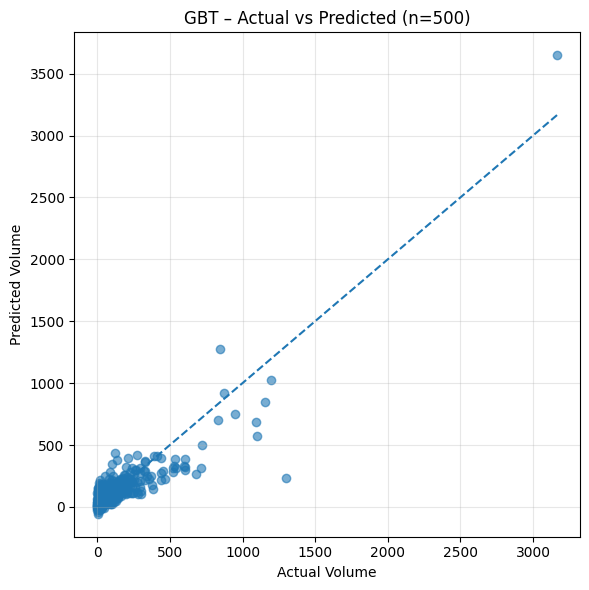

In [ ]:
# Predict on a small sample of the test set (for visualization)
sample_preds = (
    best_model
    .transform(test_df.limit(500))      # Take 500 random samples from the test set
    .select("prediction", "label")
    .toPandas()                         # Convert to Pandas for plotting
)

# View the first few predictions
print(sample_preds.head())

# --- Scatter plot: Actual vs Predicted ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(sample_preds["label"], sample_preds["prediction"], alpha=0.6)  # Actual vs predicted
plt.plot([sample_preds.label.min(), sample_preds.label.max()],
         [sample_preds.label.min(), sample_preds.label.max()], '--')       # Diagonal line = perfect prediction
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title(f"{best_name} – Actual vs Predicted (n=500)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### **Inference**

The below code simulates a real-time prediction using manually entered inputs (e.g., for a future hour in Manhattan). It shows how to run the model on new data and get predicted traffic volume.

In [ ]:
from pyspark.sql import Row

# Create a new example input for prediction (change values as needed)
one_hour_ahead = spark.createDataFrame([
    Row(yr=2025, m=4, d=24, hh=15, dow=5, boro="MANHATTAN", direction="N")
])

# Run the model on the new input
prediction_df = best_model.transform(one_hour_ahead)

# Show the predicted volume
prediction_df.select("prediction").show(truncate=False)


+-----------------+
|prediction       |
+-----------------+
|156.5529470198405|
+-----------------+

